# Final Alpha-Zero main code

# State

In [ ]:
import numpy as np

class State:
    '''
    input: board_size, pieces, enemy_pieces
    한 state에 대한 정보와 게임 플레이 관련 메서드를 포함한 클래스이다.
    '''
    def __init__(self, board_size=3, pieces=None, enemy_pieces=None):
        self.board_size = board_size # 게임 보드 한 변의 길이

        # 자신의 수와 상대의 돌을 원핫으로 표현 (dim: (3, 3))
        self.pieces = np.zeros(board_size * board_size, dtype=int) if pieces is None else np.array(pieces)
        self.enemy_pieces = np.zeros(board_size * board_size, dtype=int) if enemy_pieces is None else np.array(enemy_pieces)


    def piece_count(self, pieces):
        '''
        이 state의 전체 돌의 개수를 반환한다.
        '''
        return np.sum(pieces)

    def is_lose(self):
        '''
        이 state의 lose 여부를 반환한다.
        Note: 이 state에서 행동을 하기 전에 lose 여부를 확인한다.
        따라서 이 state가 lose라면, 이전 state에서 상대의 행동으로 상대가 승리한 경우이다.
        '''
        board = self.enemy_pieces.reshape(self.board_size, self.board_size)

        return any(
            np.all(line == 1) for line in
            np.vstack([
                board,  # 행
                board.T,  # 열
                np.diag(board),  # 대각선
                np.diag(np.fliplr(board))  # 반대 대각선
            ])
        )

    def is_draw(self):
        '''
        이 state의 draw 여부를 반환한다.
        '''
        return self.piece_count(self.pieces) + self.piece_count(self.enemy_pieces) == self.board_size * self.board_size

    def is_done(self):
        '''
        이 state의 게임 종료 여부를 반환한다.
        종료 조건: 상대방이 승리 or 무승부
        '''
        return self.is_lose() or self.is_draw()

    def next(self, action):
        '''
        이 state에서 주어진 action(칸)에 돌을 놓은 후 다음 state를 반환한다.
        '''
        pieces = self.pieces.copy()
        pieces[action] = 1
        return State(self.board_size, self.enemy_pieces, pieces)

    def legal_actions(self):
        '''
        가능한 행동(빈 칸의 위치)의 인덱스를 1차원 Numpy array로 반환한다.
        '''
        return np.where((self.pieces + self.enemy_pieces) == 0)[0]

    def to_feature(self):
        '''
        이 state를 신경망 입력 형태로 변환한다. (2, board_size, board_size)
        '''
        return np.stack([
            self.pieces.reshape(self.board_size, self.board_size),
            self.enemy_pieces.reshape(self.board_size, self.board_size)
        ], axis=0)

    def __str__(self):
        '''
        이 state를 문자열로 출력한다.
        '''
        ox = ('o', 'x') if np.sum(self.pieces) == np.sum(self.enemy_pieces) else ('x', 'o')
        board = np.full(self.board_size * self.board_size, '-')
        board[self.pieces == 1] = ox[0]
        board[self.enemy_pieces == 1] = ox[1]
        return '\n'.join([
            ''.join(board[i:i + self.board_size]) for i in range(0, self.board_size * self.board_size, self.board_size)
        ])

    def get_total_state(self):
        '''
        전체 state를 반환한다. (dim: (3, 3))
        1: 자신의 돌, -1: 상대의 돌
        '''
        board = np.zeros(self.board_size * self.board_size, dtype=int)
        board[self.pieces == 1] = 1   # 자신의 돌
        board[self.enemy_pieces == 1] = -1  # 상대의 돌 (반대 방향)
        return board.reshape(self.board_size, self.board_size)

# Dual Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    '''
    잔차 연결을 통해 학습을 돕는 Residual Block 클래스이다.
    '''
    def __init__(self, n_filters=128):
        super().__init__()
        self.conv1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1, bias=False) # 첫번째 3X3 컨볼루션
        self.bn1 = nn.BatchNorm2d(n_filters) # 첫번째 배치 정규화
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1, bias=False) # 두번째 3X3 컨볼루션
        self.bn2 = nn.BatchNorm2d(n_filters) # 두번째 배치 정규화

    def forward(self, x):
        shortcut = x # 잔차 연결용 - 원래 입력값을 보존
        x = F.relu(self.bn1(self.conv1(x))) # 첫번째 컨볼루션 -> 배치 정규화 -> Relu 활성화 함수
        x = self.bn2(self.conv2(x)) # 두번째 컨볼루션 -> 배치 정규화
        '''
        x(변형된 값)에 shortcut(원래 입력값)을 더한 후 Relu 활성화 함수를 적용하여 최종 출력을 반환한다.
        이를 통해 네트워크가 학습하기 쉬운 identity mapping(항등 함수)를 구현할 수 있다.
        '''
        return F.relu(x + shortcut)


class DualNetwork(nn.Module):
    '''
    AlphaZero에서 사용되는 정책과 가치 예측을 위한 듀얼 네트워크 구조를 구현한 것이다.
    '''
    def __init__(self, board_size, input_channels=2, n_filters=128, n_res_blocks=16):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, n_filters, kernel_size=3, padding=1, bias=False) # 초기 3X3 컨볼루션
        self.bn1 = nn.BatchNorm2d(n_filters) # 초기 배치 정규화
        '''
        RResidualBlock들을 연속적으로 쌓은 레이어 - 네트워크의 깊이를 증가시켜 복잡한 특징을 학습한다.
        '''
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(n_filters) for _ in range(n_res_blocks)]
        )
        self.global_pool = nn.AdaptiveAvgPool2d(1) # 전역 평균 풀링 - 공간 차원 축소

        # policy(정책): 각 보드 위치에 대한 확률을 예측
        self.policy_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_filters, board_size * board_size)
        )
        # value(가치): 현재 상태 가치를 -1과 1 사이의 값으로 예측
        self.value_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_filters, 1),
            nn.Tanh()
        )

    def forward(self, x):
        '''
        input x : (배치 크기, 채널, 보드 크기, 보드 크기)
        '''
        x = F.relu(self.bn1(self.conv1(x))) # 초기 컨볼루션 -> 배치 정규화 -> Relu 활성화 함수
        x = self.res_blocks(x) # 여러 ResidualBlock들을 통과
        x = self.global_pool(x)
        # 정책(head)과 가치(head)를 각각 계산하여 반환
        policy = self.policy_head(x)
        value = self.value_head(x)
        return policy, value

# MCTS

In [ ]:
C_PCUT = 1.0 # 탐험과 탐욕적 행동 선택 균형
PV_EVALUATE_COUNT = 100

In [ ]:
from math import sqrt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 추론
def predict(model, state, board_size):
    '''
    주어진 게임 상태(state)에 대해 신경망(model)을 사용하여
    정책(policy)과 가치(value)를 예측한다.
    '''
    # 입력 데이터 정규화
    x = np.array([state.pieces, state.enemy_pieces], dtype=np.float32) / 1.0 
    x = x.reshape(2, board_size, board_size).transpose(0, 1, 2).reshape(1, 2, board_size, board_size)
    x = torch.tensor(x, dtype=torch.float32).to(device)

    with torch.no_grad():
        policy, value = model(x) # 신경망으로 정책 및 가치 예측
        policy = policy.cpu().numpy().flatten()
        value = value.cpu().numpy().flatten()

    legal_actions = state.legal_actions()
    policies = policy[legal_actions]
    policy_sum = policies.sum()
    if policy_sum > 0:
        policies /= policy_sum
    else:
        policies = np.ones_like(policies) / len(policies)
    return policies, value[0]

class MCTSNode:
    '''
    MCTS에서 사용되는 각 노드를 구현한 클래스.
    각 노드는 하나의 게임 상태를 나타내며
    해당 상태에서 가능한 행동에 대한 정보를 담고 있다.
    '''
    def __init__(self, state, p, c_puct=C_PCUT):
        self.state = state
        self.p = p # 신경망에서 예측한 정책 확률
        self.w = 0 # 노드 누적 보상
        self.n = 0 # 노드 방문 횟수
        self.c_puct = c_puct
        self.child_nodes = None

    def evaluate(self, model):
        '''
        현재 노드를 평가하는 함수.
        종료된 게임 상태인지 확인하고
        종료되지 않았다면 자식 노드를 확장하거나, 탐색을 계속 진행하면서 가치를 갱신한다.
        '''
        # 1
        if self.state.is_done(): # 종료 상태인지 확인
            value = -1 if self.state.is_lose() else 0 # 패배: -1, 무승부: 0
            # 보상 누계와 시행 횟수 갱신
            self.w += value
            self.n += 1
            return value

        # 2
        # 자식 노드가 존재하지 않는 경우
        if not self.child_nodes:
            # 신경망으로 정책 및 가치 예측
            policies, value = predict(model, self.state, self.state.board_size)
            # 보상 누계와 시행 횟수 갱신
            self.w += value
            self.n += 1
            # 자식 노드 전개(확장)
            self.child_nodes = []
            for action, policy in zip(self.state.legal_actions(), policies):
              self.child_nodes.append(MCTSNode(self.state.next(action), policy, c_puct = self.c_puct))
            return value


        # 3
        else:
            # UCB1이 가장 큰 자식 노드를 평가해 가치 얻기
            # 탐색-활용(Exploration-Exploitation) 균형 전략 중 하나
            value = -self.next_child_node().evaluate(model)
            # 보상 누계와 시행 횟수 갱신
            self.w += value
            self.n += 1
            return value

    def next_child_node(self):
        '''
        UCB1(Upper Confidence Bound1) 공식을 사용하여
        탐험과 탐욕적 행동 간의 균형을 맞추는 방식으로 자식 노드를 선택한다.
        '''
        # 공식
        t = sum(child.n for child in self.child_nodes)
        pucb_values = []
        for child_node in self.child_nodes:
          pucb_values.append((-child_node.w/child_node.n if child_node.n else 0.0)+
                             self.c_puct * child_node.p * sqrt(t) / (1 + child_node.n))
        return self.child_nodes[np.argmax(pucb_values)] # 최대값 출력


def nodes_to_scores(nodes):
    '''
    노드 리스트를 시행 횟수 리스트로 변환한다.
    '''
    return [node.n for node in nodes]


def boltzman(xs, temperature):
    '''
    볼츠만 분포 계산
    '''
    xs = [x ** (1 / temperature) for x in xs]
    return [x / sum(xs) for x in xs]

# 몬테카를로 트리 탐색
def pv_mcts_scores(model, state, temperature):
    '''
    트리 탐색을 통해서 상태(state)에서 가능한 각 행동에 대한 확률 분포를 계산한다.
    여러 번의 시뮬레이션 후, 각 자식 노드의 방문 횟수를 점수로 변환하고,
    볼츠만 분포를 사용하여 확률을 결정한다.
    '''
    # 현재 상태의 루트 노드 생성
    root_node = MCTSNode(state, 0)

    # 시뮬레이션 반복 실행
    for _ in range(PV_EVALUATE_COUNT):
        root_node.evaluate(model)

    # 자식 노드 방문 횟수를 점수로 변환
    scores = nodes_to_scores(root_node.child_nodes)

    if temperature == 0: # 최대값인 경우에만 1
        action = np.argmax(scores)
        policy = np.zeros(len(scores))
        policy[action] = 1
    else:
        policy = boltzman(scores, temperature) # 볼츠만 분포를 기반으로 분산 추가
    return policy


# 몬테카를로 트리 탐색을 활용한 행동 선택
def pv_mcts_action(model, temperature=0):
    '''
    pv_mcts_scores()를 사용하여 상태에 대한 확률적 action selector를 반환하는 함수.
    temperature 값을 통해 탐험과 탐욕적 행동의 균형을 조절한다.
    '''
    def action_selector(state):
        scores = pv_mcts_scores(model, state, temperature) # 각 행동에 대한(상태에 기반) 확률분포 계산
        return np.random.choice(state.legal_actions(), p=scores) # 하나의 행동을 확률적으로 선택
    return action_selector

def mcts_simulation(root_node, model, simulations=100):
    '''
    여러 번의 시뮬레이션을 통해 주어진 루트 노드에서 가능한 행동들에 대한 확률을 계산한다.
    각 자식 노드의 방문 횟수를 기준을 정책을 계산한다.
    '''
    for _ in range(simulations):
        root_node.evaluate(model)
    # 방문 횟수 기준 정책 계산
    child_visits = [child.n for child in root_node.child_nodes]
    policy = np.array(child_visits) / sum(child_visits)
    return root_node, policy # 현재 게임 상태, 정책

# self play

In [ ]:
def self_play_game(model, board_size=3, simulations=100, temperature=0):
    '''
    MCTS를 활용해 self-play 게임을 진행하고,
    각 상태에서 정책과 보상을 저장하여 상태, 정책, 보상 데이터를 반환한다.
    '''
    state = State(board_size=board_size)
    game_data = []

    while not state.is_done():
        # 현재 상태에서 MCTS 기반 점수 계산
        scores = pv_mcts_scores(model, state, temperature)

        # 점수를 고정 크기 정책으로 변환
        '''
        정책 벡터가 보드의 크기와 맞춰지고, 유효한 행동만 확률로 유지
        '''
        full_policy = np.zeros(board_size * board_size, dtype=np.float32)
        legal_actions = state.legal_actions()  # 유효한 행동 리스트
        full_policy[legal_actions] = scores
        game_data.append((state.to_feature(), full_policy))

        # 확률적으로 행동 선택
        action = np.random.choice(state.legal_actions(), p=scores)
        state = state.next(action)

    # 게임 종료 후 보상 계산
    reward = 1 if not state.is_lose() else -1
    game_data = [(s, p, reward) for s, p in game_data]
    return game_data

# Train Model

In [ ]:
def train_model(model, scheduler, optimizer, game_data, epochs=1, batch_size=64):
    '''
    self-play로 얻은 데이터를 활용해 정책 및 가치함수를 학습한다.
    배치단위로 손실을 계산하고 최적화하며, 스케줄러를 통해 학습률을 조정한다.
    '''
    model.train()
    loss_fn_policy = torch.nn.CrossEntropyLoss()
    loss_fn_value = torch.nn.MSELoss()

    # 데이터를 PyTorch 텐서로 변환
    states, policies, values = zip(*game_data)

    states = torch.tensor(states, dtype=torch.float32).to(device)
    policies = torch.tensor(policies, dtype=torch.float32).to(device)
    values = torch.tensor(values, dtype=torch.float32).unsqueeze(1).to(device)

    dataset = torch.utils.data.TensorDataset(states, policies, values)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss, total_policy_loss, total_value_loss = 0, 0, 0

        for inputs, targets_policy, targets_value in data_loader:
            inputs = inputs.to(device)
            targets_policy = targets_policy.to(device)
            targets_value = targets_value.to(device)

            # 모델예측
            predicted_policies, predicted_values = model(inputs)

            loss_policy = loss_fn_policy(predicted_policies, targets_policy)
            loss_value = loss_fn_value(predicted_values, targets_value)
            loss = 0.5*loss_policy + loss_value # policy가 너무 크게 나와서 앞에 0.5 곱해줌 이래도 되나..

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_policy_loss += loss_policy.item()
            total_value_loss += loss_value.item()

        # 에포크별 평균 기록
        training_metrics["loss"].append(total_loss / len(data_loader))
        training_metrics["policy_loss"].append(total_policy_loss / len(data_loader))
        training_metrics["value_loss"].append(total_value_loss / len(data_loader))

        scheduler.step() # scheduler는 마지막에

# Evaluate model

In [ ]:
def evaluate_models(new_model, old_model, games=20, board_size=3):
    '''
    AlphaZero의 신경망 모델을 서로 대결시켜
    새 모델과 이전 모델의 성능을 비교하는 방식으로 평가한다.
    각 모델의 승리 횟수를 통해 모델의 우수성을 판단한다.

    new_model: 새로 학습된 신경망 모델
    old_model: 이전에 학습된 신경망 모델
    games: 두 모델이 대결한 게임의 수
    board_size: 게임판 크기(3x3)
    '''
    new_wins, old_wins = 0, 0 # 각 모델의 승리 횟수를 기록하는 변수
    temperature = 1.0

    for _ in range(games):
        state = State(board_size=board_size)
        current_player = new_model

        while not state.is_done():
            scores = pv_mcts_scores(current_player, state, temperature)
            action = np.random.choice(state.legal_actions(), p=scores)
            state = state.next(action)

            # 플레이어 교체
            current_player = old_model if current_player == new_model else new_model

        if state.is_lose():
            if current_player == new_model:
                old_wins += 1
            else:
                new_wins += 1

    # 승리 결과 기록
    evaluation_metrics["new_model_wins"].append(new_wins)
    evaluation_metrics["old_model_wins"].append(old_wins)
    return new_wins, old_wins

# w/ Robot

In [ ]:
from connect_CNC import *

In [ ]:
# 
def make_state(raw_state):
    my_actions = np.where(raw_state == 1)[0]
    enemy_actions = np.where(raw_state == -1)[0]
    my_state = np.zeros(STATE_SIZE)
    my_state[my_actions] = 1
    enemy_state = np.zeros(STATE_SIZE)
    enemy_state[enemy_actions] = 1

    state = State(pieces = my_state, enemy_pieces = enemy_state)

    return state

In [ ]:
model = # best model
board_size=3
temperature = 0

alphazero_first = input("Is Alpha-Zero first?: (True/False)")
agent_turn = "O" if alphazero_first else "X"
alphazero_turn = 1 if alphazero_first else 0
serial = Serial('/dev/cu.usbserial-110', alphazero_first)

state = State(board_size=board_size)

n_steps = 0
while not state.is_done():
    n_steps += 1
    if n_steps % 2 == alphazero_turn:
        scores = pv_mcts_scores(model, state, temperature)
        action = np.random.choice(state.legal_actions(), p=scores)

        serial.send_to_robot(agent_turn, str(action))
        state = state.next(action)

    else:
        raw_state = image_to_state(state)
        state = make_state(raw_state)
        is_done = state.check_done()

if state.is_draw():
    print("Draw!")

else:
    if n_steps % 2 == alphazero_turn:
        print("Alpha-Zero Win!")
    else:
        print("You Win!")


# Final

In [ ]:
import matplotlib.pyplot as plt

def plot_graph():
    # 그래프
    plt.figure(figsize=(15, 5))

    # 1. 정책 정확도 그래프
    plt.subplot(1, 3, 1)
    plt.plot(training_metrics["policy_loss"], label="Policy Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Policy Loss Over Epochs")
    plt.legend()

    # 2. 손실 그래프 (전체 손실과 가치 손실)
    plt.subplot(1, 3, 2)
    plt.plot(training_metrics["loss"], label="Total Loss", marker="o")
    plt.plot(training_metrics["value_loss"], label="Value Loss", marker="x")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # 3. 승률 그래프 (새 모델 vs 기존 모델 승리 횟수)
    plt.subplot(1, 3, 3)
    plt.plot(evaluation_metrics["new_model_wins"], label="New Model Wins", marker="o")
    plt.plot(evaluation_metrics["old_model_wins"], label="Old Model Wins", marker="x")
    plt.xlabel("Iterations")
    plt.ylabel("Wins")
    plt.title("Model Evaluation Results")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
BOARD_SIZE = 3
LEARNING_RATE = 2e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
SIMULATIONS = 120
GAMES_PER_ITERATION = 8
EVALUATION_GAMES = 140
ITERATIONS = 3

Iteration 1
New Model Wins: 83, Old Model Wins: 43, Loss: 0.13935230672359467, Value Loss: 0.00010535803448874503
New Model Win Rate: 65.87%
Iteration 2
New Model Wins: 69, Old Model Wins: 43, Loss: 0.29227298498153687, Value Loss: 2.382708953518886e-05
New Model Win Rate: 61.61%
Iteration 3
New Model Wins: 79, Old Model Wins: 39, Loss: 0.16655628383159637, Value Loss: 3.310593683636398e-06
New Model Win Rate: 66.95%


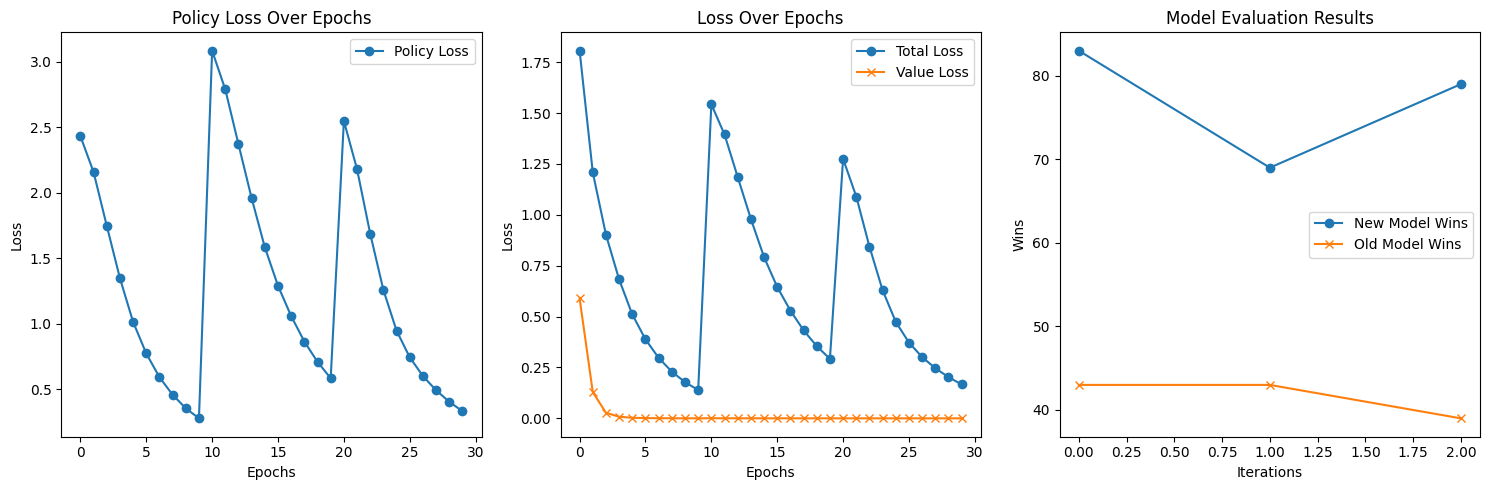

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

model = DualNetwork(BOARD_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

old_model =  DualNetwork(BOARD_SIZE).to(device)
old_model.load_state_dict(model.state_dict())

training_metrics = {
    "loss": [],
    "policy_loss": [],
    "value_loss": []
}

evaluation_metrics = {
    "new_model_wins": [],
    "old_model_wins": []
}

for iteration in range(ITERATIONS):
    print(f"Iteration {iteration + 1}")
    game_data = []
    for _ in range(GAMES_PER_ITERATION):
        game_data = self_play_game(model, BOARD_SIZE, simulations=SIMULATIONS)
    train_model(model, scheduler, optimizer, game_data, epochs=10)

    new_wins, old_wins = evaluate_models(model, old_model, games=EVALUATION_GAMES)
    last_loss = training_metrics['loss'][-1] # 어떤 행동을 취해야 할지(정책)와 그 상태가 얼마나 좋은지(가치)를 학습
    last_value_loss = training_metrics['value_loss'][-1] # 정확한 승리 확률이나 기대 보상을 예측하도록 학습
    print(f"New Model Wins: {new_wins}, Old Model Wins: {old_wins}, Loss: {last_loss}, Value Loss: {last_value_loss}")

    # 승률 계산
    total_games = new_wins + old_wins
    win_rate = (new_wins / total_games * 100) if total_games > 0 else 0

    print(f"New Model Win Rate: {win_rate:.2f}%")

plot_graph()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/kanghwa/trained_tic_tac_toe_model.pth")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualNetwork(BOARD_SIZE)
model.load_state_dict(torch.load("/content/drive/MyDrive/kanghwa/trained_tic_tac_toe_model.pth"))
model.to(device)  # 모델을 GPU로 이동
model.eval()

<ipython-input-11-858372f6c1ce>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/kanghwa/trained_tic_tac_toe_model.p

DualNetwork(
  (conv1): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=Tr

In [ ]:
import numpy as np
import torch

def play_against_ai(model, board_size=3):
    state = State(board_size=board_size)

    # 선공 결정
    first_player = input("누가 먼저 시작할까요? (1: 플레이어, 2: AI): ")
    while first_player not in ['1', '2']:
        first_player = input("잘못된 입력입니다. 1 또는 2를 입력하세요: ")
    player_turn = first_player == '1'

    print("게임 시작! 당신은 'O', AI는 'X'입니다.")

    while not state.is_done():
        print(state)

        if player_turn:
            # 플레이어 차례
            action = None
            while action not in state.legal_actions():
                try:
                    action = int(input("당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: ")) - 1
                except ValueError:
                    continue
            state = state.next(action)
        else:
            # AI 차례
            print("\nAI가 수를 두는 중...")
            ai_action = pv_mcts_action(model, temperature=0)(state)
            state = state.next(ai_action)

        if state.is_done():
            break

        player_turn = not player_turn  # 턴 변경

    print(state)

    if not player_turn and state.is_lose():
        print("AI가 승리했습니다!")
    elif player_turn and state.is_lose():
        print("축하합니다! 당신이 승리했습니다!")
    elif state.is_draw():
        print("무승부입니다!")

In [ ]:
play_against_ai(model)

누가 먼저 시작할까요? (1: 플레이어, 2: AI): 1
게임 시작! 당신은 'O', AI는 'X'입니다.
---
---
---
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 5
---
-o-
---

AI가 수를 두는 중...
x--
-o-
---
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 2
xo-
-o-
---

AI가 수를 두는 중...
xo-
-o-
-x-
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 3
xoo
-o-
-x-

AI가 수를 두는 중...
xoo
-o-
xx-
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 9
xoo
-o-
xxo

AI가 수를 두는 중...
xoo
xo-
xxo
AI가 승리했습니다!


# 히트맵ver.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_board_and_heatmap(state, policy_probs):
    """현재 보드 상태와 AI의 MCTS 히트맵을 출력"""
    board_size = state.board_size
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # 왼쪽: 보드 상태
    axes[0].set_facecolor('skyblue')
    for x in range(board_size):
        axes[0].plot([x, x], [0, board_size-1], color="black", linewidth=1, zorder=1)
        axes[0].plot([0, board_size-1], [x, x], color="black", linewidth=1, zorder=1)

    # 보드 상태 가져오기
    try:
        board = state.get_total_state()  # 기존 코드
    except AttributeError:
        board = state.pieces.reshape(board_size, board_size) - state.enemy_pieces.reshape(board_size, board_size)

    for i in range(board_size):
        for j in range(board_size):
            if board[i, j] == 1:
                circle = plt.Circle((j, board_size-1 - i), 0.4, color="black", zorder=2)
                axes[0].add_artist(circle)
            elif board[i, j] == -1:
                circle = plt.Circle((j, board_size-1 - i), 0.4, facecolor='white', edgecolor="black", linewidth=1.5, zorder=2)
                axes[0].add_artist(circle)

    axes[0].set_xlim(-0.5, board_size - 0.5)
    axes[0].set_ylim(-0.5, board_size - 0.5)
    axes[0].set_aspect('equal')
    axes[0].set_title("Current Board State")

    # 오른쪽: AI의 MCTS 정책 히트맵
    full_policy = np.zeros(board_size * board_size)  # 9칸짜리 배열
    legal_actions = state.legal_actions()  # 현재 가능한 행동들

    # 해결: policy_probs의 크기를 legal_actions 크기에 맞춤
    if len(policy_probs) > len(legal_actions):
        policy_probs = policy_probs[:len(legal_actions)]

    if len(policy_probs) != len(legal_actions):
        raise ValueError(f"크기 불일치 이슈 legal_actions: {len(legal_actions)}, policy_probs: {len(policy_probs)}")

    full_policy[legal_actions] = policy_probs  # 빈 칸에만 확률 넣기
    full_policy = full_policy.reshape(board_size, board_size)  # 3x3 변환

    sns.heatmap(full_policy, annot=True, fmt='.2f', cmap='YlGnBu', cbar=True, ax=axes[1])
    axes[1].set_title("MCTS Policy")

    # AI 예상 승률 계산
    ai_win_prob = np.max(policy_probs)  # 가장 높은 확률의 액션이 AI의 예상 승률
    player_win_prob = 1 - ai_win_prob   # 상대방(플레이어) 승률

    # 승률 출력
    print(f"AI 예상 승률: {ai_win_prob * 100:.2f}%")
    print(f"플레이어 예상 승률: {player_win_prob * 100:.2f}%")

    plt.show(block=False)
    plt.pause(1)
    plt.close()

In [ ]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

def play_against_ai(model, board_size=3):
    state = State(board_size=board_size)
    game_data = []  # 게임 진행 데이터 저장 리스트

    # 선공 결정
    first_player = input("누가 먼저 시작할까요? (1: 플레이어, 2: AI): ")
    while first_player not in ['1', '2']:
        first_player = input("잘못된 입력입니다. 1 또는 2를 입력하세요: ")
    player_turn = first_player == '1'

    print("게임 시작! 당신은 'O', AI는 'X'입니다.")

    while not state.is_done():
        print(state)

        if player_turn:
            action = None
            while action not in state.legal_actions():
                try:
                    action = int(input("당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: ")) - 1
                except ValueError:
                    continue
            state = state.next(action)
        else:
            print("\nAI가 수를 두는 중...")

            # MCTS 실행하여 확률 계산
            root_node = MCTSNode(state, 1.0)  # 초기 루트 노드 설정
            root_node, policy_probs = mcts_simulation(root_node, model, simulations=100)  # MCTS 실행

            legal_actions = state.legal_actions()  # 현재 가능한 행동 가져오기
            ai_action = legal_actions[np.argmax(policy_probs)]

            game_data.append((state, policy_probs))  # 현재 상태와 AI의 정책 저장
            state = state.next(ai_action)

            # 시각화 실행 (보드 상태 + 히트맵)
            visualize_board_and_heatmap(state, policy_probs)

        if state.is_done():
            break

        player_turn = not player_turn

    print(state)

    if not player_turn and state.is_lose():
        print("AI가 승리했습니다!")
    elif player_turn and state.is_lose():
        print("축하합니다! 당신이 승리했습니다!")
    elif state.is_draw():
        print("무승부입니다!")

누가 먼저 시작할까요? (1: 플레이어, 2: AI): 1
게임 시작! 당신은 'O', AI는 'X'입니다.
---
---
---
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 5
---
-o-
---

AI가 수를 두는 중...
AI 예상 승률: 49.49%
플레이어 예상 승률: 50.51%


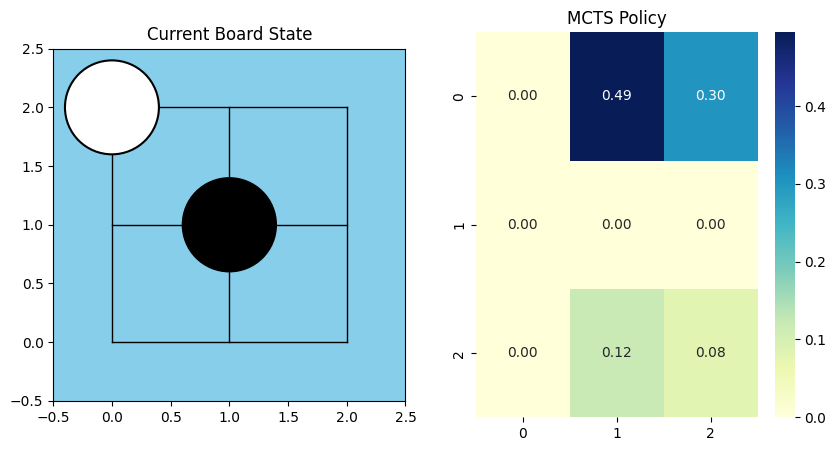

x--
-o-
---
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 4
x--
oo-
---

AI가 수를 두는 중...
AI 예상 승률: 42.42%
플레이어 예상 승률: 57.58%


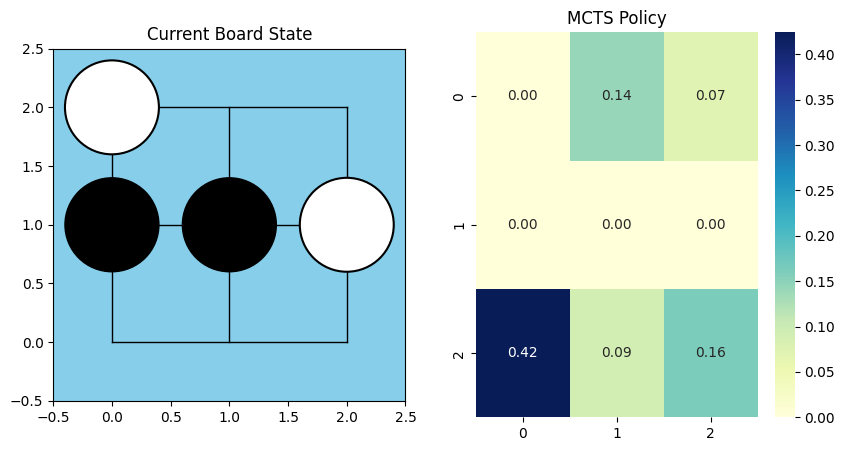

x--
oox
---
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 2
xo-
oox
---

AI가 수를 두는 중...
AI 예상 승률: 70.71%
플레이어 예상 승률: 29.29%


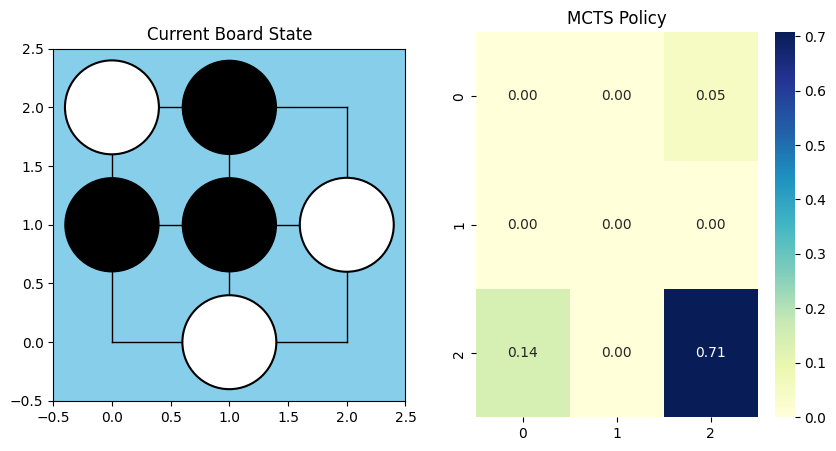

xo-
oox
-x-
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 3
xoo
oox
-x-

AI가 수를 두는 중...
AI 예상 승률: 90.91%
플레이어 예상 승률: 9.09%


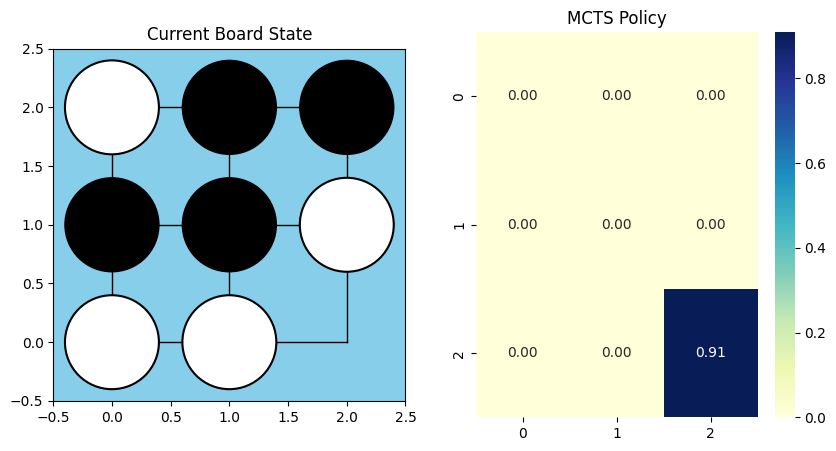

xoo
oox
xx-
당신의 차례입니다. 1~9 중 빈 칸을 선택하세요: 9
xoo
oox
xxo
무승부입니다!


In [ ]:
play_against_ai(model)